# Cluster Analysis

## 1. K-Means Clustering 
### Assumptions

* The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
* Each point is closer to its own cluster center than to other cluster centers.

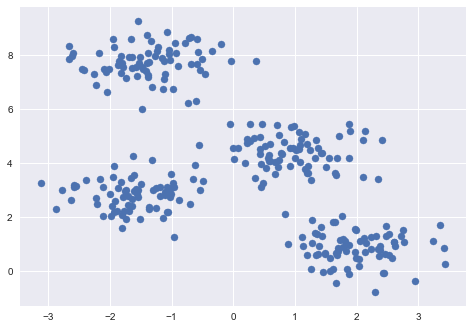

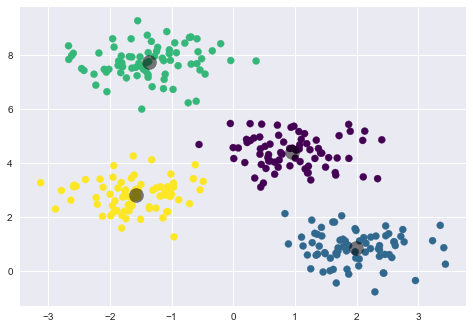

In [12]:
# Import Packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

# Generate two-dimensional dataset containing four distinct blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

# k-means algorithm
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Visulize the result
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

## 2. K-Means Algorithm: Expectation–Maximization
Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm. In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged

  E-Step: assign points to the nearest cluster center
    
  M-Step: set the cluster centers to the mean

![algorithm](algorithm.gif "algorithm")

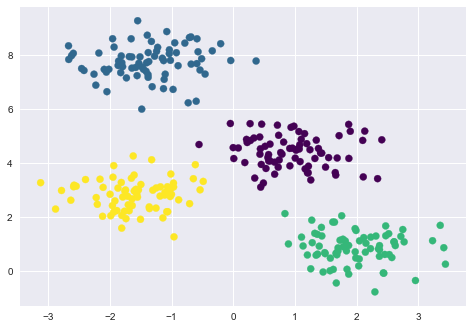

In [2]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)

plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')
plt.show()

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

## 3. Hierarchical Clustering

One of the benefits of hierarchical clustering is that you don't need to already know the number of clusters k in your data in advance.

In [18]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.colors as colors

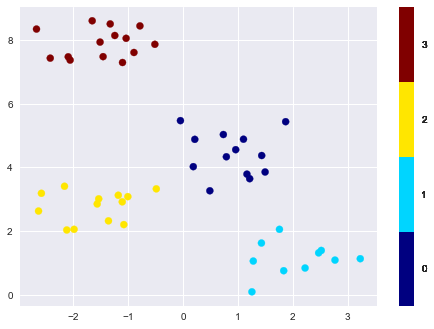

In [19]:
rng = np.random.RandomState(123)
i = rng.permutation(X.shape[0])[:50]

X_subset = X[i]
y_true_subset = y_true[i]

cmap = plt.cm.get_cmap('jet',max(y_true_subset)-min(y_true_subset)+1)
bounds = range(min(y_true_subset),max(y_true_subset)+2)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(X_subset[:, 0], X_subset[:, 1], s=50, c=y_true_subset, cmap=cmap, norm=norm)
cb=plt.colorbar(ticks=np.array(y_true_subset)+0.5)
cb.set_ticklabels(y_true_subset)
plt.show()

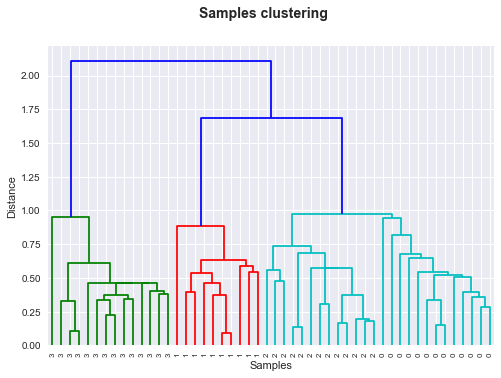

In [20]:
data_dist = pdist(X_subset)
data_link = linkage(data_dist)

dendrogram(data_link,labels=y_true_subset)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14)
plt.show()

## 4. Application in Color Compression

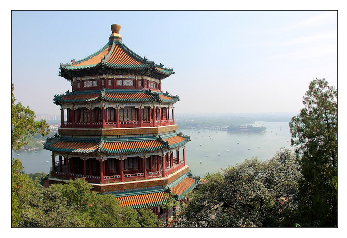

In [2]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from sklearn.cluster import MiniBatchKMeans

# Load image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)
plt.show()

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255. We can view this set of pixels as a cloud of points in a three-dimensional color space.

In [3]:
china.shape

(427, 640, 3)

Reshape the data to [n_samples x n_features], and rescale the colors so that they lie between 0 and 1

In [4]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

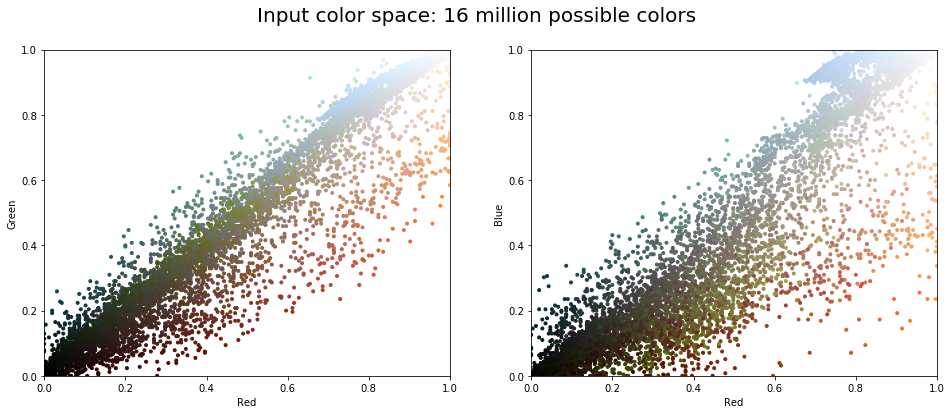

In [5]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);
    
plot_pixels(data, title='Input color space: 16 million possible colors')
plt.show()

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

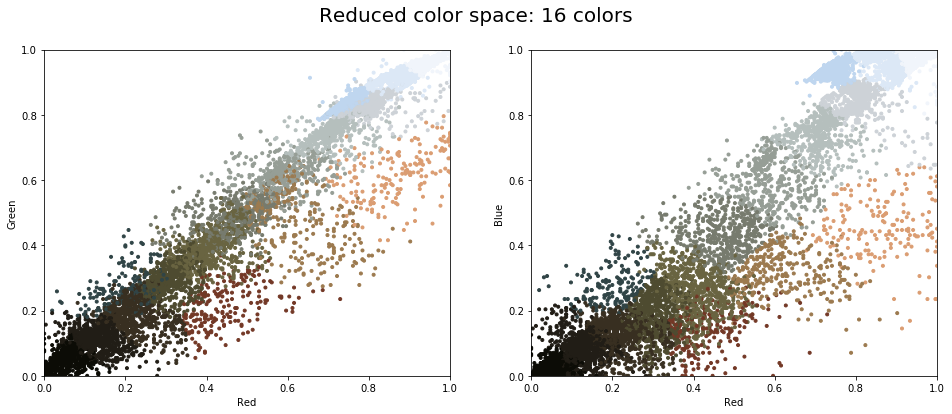

In [8]:
kmeans = MiniBatchKMeans(16)   # 16 clusters
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]   

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")
plt.show()

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this

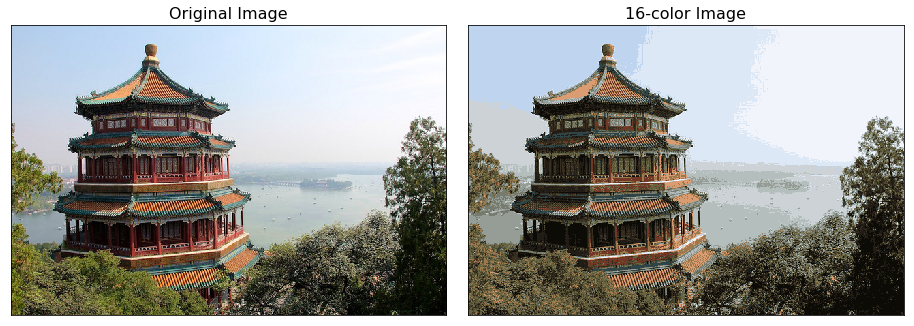

In [11]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)
plt.show()